In [ ]:
#default_exp model

# Base Model
> This class contains the base which is used to train data upon.

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
from dataclasses import dataclass
from datetime import datetime
from typing import Callable, List, Optional, Tuple

import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchlife.models.ph import PieceWiseHazard
from torchlife.models.cox import ProportionalHazard
from torchlife.models.aft import AFTModel
from torchlife.data import create_dl, create_test_dl, get_breakpoints
from torchlife.losses import aft_loss, hazard_loss, Loss, HazardLoss, AFTLoss

In [ ]:
# hide
import matplotlib.pyplot as plt
%matplotlib inline

## General Model

In [ ]:
# export
class GeneralModel(pl.LightningModule):
    def __init__(
        self,
        base: nn.Module,
        loss_fn: Loss,
        lr: float = 1e-3,
    ) -> None:
        """
        n_features: The number of real valued feature.
        n_layers: Number of Deep learning layers.
        loss_fn: Loss function.
        n_cats: List of integers containing the number of unique values per category.
        """
        super().__init__()
        self.base = base
        self.loss_fn = loss_fn
        self.lr = lr
        
    def forward(self, x):
        return self.base(*x)
    
    def common_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.LongTensor]:
        x, e = batch
        density_term, cumulative_term = self(x)
        loss = self.loss_fn(e.squeeze(), density_term.squeeze(), cumulative_term.squeeze())
        
        if torch.isnan(loss):
            breakpoint()
        return loss
    
    def training_step(self, batch, *args):
        loss = self.common_step(batch)
        self.log("training_loss", loss, on_step=True, on_epoch=True)
    
    def validation_step(self, batch, *args):
        loss = self.common_step(batch)
        self.log("val_loss", loss, on_step=True, on_epoch=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return {
            "optimizer": optimizer,
            "lr_scheduler": ReduceLROnPlateau(optimizer, patience=2),
            "monitor": "val_loss"
        }

In [ ]:
# export
def train_model(model, train_dl, valid_dl, epochs):
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="./models/",
        filename= "model-{epoch:02d}-{val_loss:.2f}",
        save_last=True,
    )
    early_stopping = EarlyStopping("val_loss")

    trainer = pl.Trainer(
        max_epochs=epochs,
        gpus=torch.cuda.device_count(),
        callbacks=[early_stopping, checkpoint_callback]
    )
    trainer.fit(model, train_dl, valid_dl)

## Data for Demo

In [ ]:
# hide
import pandas as pd
import numpy as np
url = "https://raw.githubusercontent.com/CamDavidsonPilon/lifelines/master/lifelines/datasets/rossi.csv"
df = pd.read_csv(url)
df.rename(columns={'week':'t', 'arrest':'e'}, inplace=True)

In [ ]:
print(df.shape)
df.head()

(432, 9)


,t,e,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


## Hazard Model

In [ ]:
# export
_text2model_ = {
    'ph': PieceWiseHazard,
    'cox': ProportionalHazard
}

class ModelHazard:
    """
    Modelling instantaneous hazard (λ).
    parameters:
    - model(str): ['ph'|'cox'] which maps to Piecewise Hazard, Cox Proportional Hazard.
    - percentiles: list of time percentiles at which time should be broken
    - h: list of hidden units (disregarding input units)
    - bs: batch size
    - epochs: epochs
    - lr: learning rate
    - beta: l2 penalty on weights
    """
    def __init__(self, model:str, percentiles=[20, 40, 60, 80], h:tuple=(),
                 bs:int=128, epochs:int=20, lr:float=1.0, beta:float=0):
        self.base_model = _text2model_[model]
        self.percentiles = percentiles
        self.loss_fn = HazardLoss()
        self.h = h
        self.bs, self.epochs, self.lr, self.beta = bs, epochs, lr, beta
        
    def fit(self, df):
        breakpoints = get_breakpoints(df, self.percentiles)
        train_dl, valid_dl, t_scaler, x_scaler = create_dl(df, breakpoints)
        dim = df.shape[1] - 2
        assert dim > 0, ValueError("dimensions of x input needs to be >0. Choose ph instead")

        model_args = {
            'breakpoints': breakpoints, 
            't_scaler': t_scaler, 
            'x_scaler': x_scaler, 
            'h': self.h, 
            'dim': dim
        }
        self.model = GeneralModel(
            self.base_model(**model_args),
            self.loss_fn,
            self.lr
        )
        
        self.breakpoints = breakpoints
        self.t_scaler = t_scaler
        self.x_scaler = x_scaler
        train_model(self.model, train_dl, valid_dl, self.epochs)
            
    def predict(self, df):
        test_dl = create_test_dl(df, self.breakpoints, self.t_scaler, self.x_scaler)
        with torch.no_grad():
            self.model.eval()
            λ, S = [], []
            for x in test_dl:
                preds = self.model(x)
                λ.append(torch.exp(preds[0]))
                S.append(torch.exp(-preds[1]))
            return torch.cat(λ), torch.cat(S)
        
    def plot_survival_function(self, *args):
        self.model.base.plot_survival_function(*args)

## Cox Model Demo

In [ ]:
model = ModelHazard('cox')
model.fit(df)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name | Type               | Params
--------------------------------------------
0 | base | ProportionalHazard | 12    
--------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
Epoch 0:  75%|███████▌  | 3/4 [00:00<00:00, 21.84it/s, loss=nan, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 1:  75%|███████▌  | 3/4 [00:00<00:00, 20.65it/s, loss=nan, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 2:  75%|███████▌  | 3/4 [00:00<00:00, 21.48it/s, loss=nan, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 3:  75%|███████▌  | 3/4 [00:00<00:00, 20.85it/s, loss=nan, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 13.30it/s, loss=nan, v_num=47]
                                                         Saving latest checkpoint...
Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 12.95it/s, loss=nan, v_num=47]


In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir ./lightning_logs/

In [ ]:
λ, Λ = model.predict(df)
df.shape, λ.shape, Λ.shape

((432, 9), torch.Size([432, 1]), torch.Size([432, 1]))

## Modelling Distribution with [AFT](./AFT_models) models

In [ ]:
# export
from torchlife.models.error_dist import *

class ModelAFT:
    """
    Modelling error distribution given inputs x.
    parameters:
    - dist(str): Univariate distribution of error
    - h: list of hidden units (disregarding input units)
    - bs: batch size
    - epochs: epochs
    - lr: learning rate
    - beta: l2 penalty on weights
    """
    def __init__(self, dist:str, h:tuple=(),
                 bs:int=128, epochs:int=20, lr:float=0.1, beta:float=0):
        self.dist = dist
        self.loss_fn = AFTLoss()
        self.h = h
        self.bs, self.epochs, self.lr, self.beta = bs, epochs, lr, beta
        
    def fit(self, df):
        train_dl, valid_dl, self.t_scaler, self.x_scaler = create_dl(df)
        dim = df.shape[1] - 2
        aft_model = AFTModel(self.dist, dim, self.h)
        self.model = GeneralModel(
            aft_model,
            self.loss_fn,
            self.lr
        )
        
        train_model(self.model, train_dl, valid_dl, self.epochs)
            
    def predict(self, df):
        """
        Predicts the survival probability
        """
        test_dl = create_test_dl(df)
        with torch.no_grad():
            self.model.eval()
            Λ = []
            for x in test_dl:
                _, logΛ = self.model(x)
                Λ.append(torch.exp(logΛ))
            return torch.cat(Λ).cpu().numpy()
        
    def predict_time(self, df):
        """
        Predicts the mode (not average) time expected for instance.
        """
        if "t" not in df.columns:
            df["t"] = 0
        test_dl = create_test_dl(df)
        with torch.no_grad():
            self.model.eval()
            μ = []
            for _, x in test_dl:
                logμ, _ = self.model.base.get_mode_time(x)
                μ.append(torch.exp(logμ))
            return self.t_scaler.inverse_transform(torch.cat(μ).cpu().numpy())
        
    def plot_survival(self, t, x):
        self.model.plot_survival_function(t, self.t_scaler, x, self.x_scaler)

In [ ]:
model = ModelAFT('Gumbel')
model.fit(df)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name | Type     | Params
----------------------------------
0 | base | AFTModel | 9     
----------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
Epoch 0:  75%|███████▌  | 3/4 [00:00<00:00, 18.74it/s, loss=nan, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 1:  75%|███████▌  | 3/4 [00:00<00:00, 19.59it/s, loss=nan, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 2:  75%|███████▌  | 3/4 [00:00<00:00, 20.76it/s, loss=nan, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 3:  75%|███████▌  | 3/4 [00:00<00:00, 20.85it/s, loss=nan, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 13.83it/s, loss=nan, v_num=48]
                                                         Saving latest checkpoint...
Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 13.50it/s, loss=nan, v_num=48]


In [ ]:
surv_prob = model.predict(df)
mode_time = model.predict_time(df)

In [ ]:
df["surv_prob"] = surv_prob
df["mode_time"] = mode_time
df

,t,e,fin,age,race,wexp,mar,paro,prio,surv_prob,mode_time
0,20,1,0,27,1,0,0,1,3,0.954641,30.349995
1,17,1,0,18,1,0,0,1,8,0.857569,21.751127
2,25,1,0,19,0,1,0,1,13,0.049757,8.331078
3,52,0,1,23,1,1,1,1,1,0.013023,10.488750
4,52,0,0,19,0,1,0,1,3,0.021093,12.552552
...,...,...,...,...,...,...,...,...,...,...,...
427,52,0,1,31,0,1,0,1,3,0.029531,14.236526
428,52,0,0,20,1,0,0,1,1,0.198965,29.817591
429,52,0,1,20,1,1,1,1,1,0.011608,10.050090
430,52,0,0,29,1,1,0,1,3,0.076160,20.383711


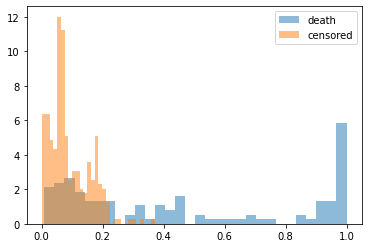

In [ ]:
plt.hist(df[df["e"] == 1]["surv_prob"].values, bins=30, alpha=0.5, density=True, label="death")
plt.hist(df[df["e"] == 0]["surv_prob"].values, bins=30, alpha=0.5, density=True, label="censored")
plt.legend()
plt.show()

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir ./lightning_logs/

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_index.ipynb.
Converted 10_SAT.ipynb.
Converted 20_KaplanMeier.ipynb.
Converted 50_hazard.ipynb.
Converted 55_hazard.PiecewiseHazard.ipynb.
Converted 59_hazard.Cox.ipynb.
Converted 60_AFT_models.ipynb.
Converted 65_AFT_error_distributions.ipynb.
Converted 80_data.ipynb.
Converted 90_model.ipynb.
Converted 95_Losses.ipynb.
